# Neuron

In [1]:
import numpy as np
from sklearn.datasets import make_classification, make_moons
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, recall_score, roc_curve, RocCurveDisplay, auc, balanced_accuracy_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd
import time

In [2]:
def metrics(y_true, y_pred):
    print('accuracy:', accuracy_score(y_true, y_pred))
    cm = confusion_matrix(y_true, y_pred)
    print('sensitivity:', recall_score(y_true, y_pred))
    print('specificity:', cm[0][0]/(cm[0][0]+cm[0][1]))
    disp = ConfusionMatrixDisplay(cm)
    disp.plot()

In [3]:
def surface(classifier, xi, yi):
    minx, maxx = min(xi[:,0]), max(xi[:,0])
    miny, maxy = min(xi[:,1]), max(xi[:,1])
    x = np.linspace(minx, maxx, 1000)
    y = np.linspace(miny, maxy, 1000)

    X, Y = np.meshgrid(x,y)
    Z = []

    for i in range(len(X)):
        for j in range(len(Y)):
            Z.append(classifier.predict(np.array([X[i,j], Y[i,j]]).reshape(1, -1)))
                    
    Z = np.reshape(Z, X.shape)
        
    plt.scatter(xi[yi==0,0], xi[yi==0,1], label='Klasa 0')
    plt.scatter(xi[yi==1,0], xi[yi==1,1], label='Klasa 1')
    plt.legend()
    plt.contourf(X, Y, Z, alpha=0.3)
    plt.show()


## Generowanie zbiorów

In [4]:
x1, y1 = make_classification(random_state=254448, n_samples=2548, n_features=2, n_redundant=0, n_informative=2, n_clusters_per_class=1)
x2, y2 = make_moons(n_samples=2548, random_state=254448, shuffle=True)

x_train1, x_test1, y_train1, y_test1 = train_test_split(x1, y1, random_state=254448, stratify=y1)
x_train2, x_test2, y_train2, y_test2 = train_test_split(x2, y2, random_state=254448, stratify=y2)

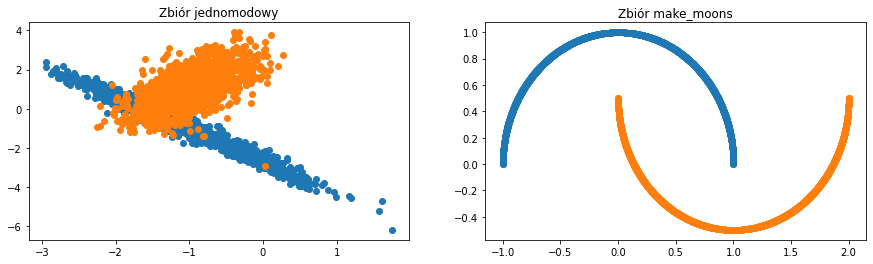

In [5]:
fig, (ax1, ax2) = plt.subplots(1,2)
fig.set_figheight(4)
fig.set_figwidth(15)

ax1.scatter(x1[y1==0,0], x1[y1==0,1])
ax1.scatter(x1[y1==1,0], x1[y1==1,1])
ax1.set_title('Zbiór jednomodowy')

ax2.scatter(x2[y2==0,0], x2[y2==0,1])
ax2.scatter(x2[y2==1,0], x2[y2==1,1])
ax2.set_title('Zbiór make_moons')

plt.show()

## Implementacja neuronu

In [52]:
class Neuron():
    'logistic, heaviside, sin, tanh, sign, ReLu, leakyRelu'
    
    def __init__(self, activation_function='logistic', eta=0.15, batch_size=64, n_epoch=100, cos_ann=False, eta_min=None, eta_max=None):
        self.activation = activation_function
        self.eta = eta
        self.batch_size = batch_size
        self.cosinus_annealing = cos_ann
        self.eta_min = eta_min
        self.eta_max = eta_max
        self.n_epoch = n_epoch
        self.current_epoch = 1
        
        gen = np.random.default_rng(seed=254448)
        self.w = gen.uniform(0, 1, (3, 1))

        if self.activation=='logistic':
            self.func = self.logistic_func
            self.derivative = self.logistic_derivative
        elif self.activation=='heaviside':
            self.func = self.heaviside_func
            self.derivative = self.heaviside_derivative
        elif self.activation=='sin':
            self.func = self.sin_func
            self.derivative = self.sin_derivative
        elif self.activation=='tanh':
            self.func = self.tanh_func
            self.derivative = self.tanh_derivative
        elif self.activation=='sign':
            self.func = self.sign_func
            self.derivative = self.sign_derivative
        elif self.activation=='relu':
            self.func = self.ReLu_func
            self.derivative = self.ReLu_derivative
        elif self.activation=='leakyrelu':
            self.func = self.leaky_ReLu
            self.derivative = self.leaky_ReLu_derivative
        
        
    def logistic_func(self, x):
        return 1/(1+np.e**-x)
    
    def logistic_derivative(self, x):
        return self.logistic_func(x)*(1-self.logistic_func(x))
    
    def heaviside_func(self, x):
        return np.where(x>=0, 1, 0)
    
    def heaviside_derivative(self, x):
        return np.where(x>-np.inf, 1, 0)
    
    def sin_func(self, x):
        return np.sin(x)
    
    def sin_derivative(self, x):
        return np.cos(x)
    
    def tanh_func(self, x):
        return np.tanh(x)
    
    def tanh_derivative(self, x):
        return 1-self.tanh_func(x)**2
    
    def sign_func(self, x):
        return 1 if x>0 else 0 if x==0 else -1
    
    def sign_derivative(self, x):
        return self.heaviside_derivative(x)
    
    def ReLu_func(self, x):
        return np.where(x>0, x, 0)
    
    def ReLu_derivative(self, x):
        return np.where(x<=0, 0, 1)
    
    def leaky_ReLu(self, x):
        return np.where(x>0, x, 0.01*x)
    
    def leaky_ReLu_derivative(self, x):
        return np.where(x>0, 1, 0.01)
    
    def cosinus_annealing_func(self, n):
        if self.cosinus_annealing:
            return self.eta_min + (self.eta_max-self.eta_min)*(1 + np.cos(n/self.n_epoch*np.pi))
        else:
            return self.eta
    
    def squared_error(self, x, y):
        wx = np.matmul(x, self.w)
        return np.sum((np.where(self.func(wx)<0.5, 0, 1).flatten()-y)**2)
    
    def gradient(self, x, y, n):
        wx = np.matmul(x, self.w)
        if self.activation=='sign':
            sgn = np.reshape(np.array([self.sign_func(x) for x in wx]), (1,-1))
            eps = y-np.where(sgn<0.5, 0, 1).flatten()
            tm = eps * self.derivative(wx).flatten()
            delta = self.cosinus_annealing_func(n)*tm[:, np.newaxis]*x
            delta_mean = np.mean(delta, axis=0)
        else:
            eps = y-np.where(self.func(wx)<0.5, 0, 1).flatten()
            tm = eps * self.derivative(wx).flatten()
            delta = self.cosinus_annealing_func(n)*tm[:, np.newaxis]*x
            delta_mean = np.mean(delta, axis=0)
        return np.reshape(delta_mean, (3,1))
    
    def fit(self, x, y):
        #pierwszy współczynnik to b
        
        n_iter = len(x)//self.batch_size
        x = np.concatenate([np.full((len(x), 1), -1), x], axis=1)
        for i in range(self.n_epoch):
            for j in range(n_iter+1):
                update = self.gradient(x[j*self.batch_size:(j+1)*self.batch_size], y[j*self.batch_size:(j+1)*self.batch_size], i)
                self.w = self.w + update

                   
    def predict(self, x):
        x = np.concatenate([np.full((len(x), 1), -1), x], axis=1)
        wx = np.matmul(x, self.w)
        if self.activation=='sign':
            return np.array(np.where(np.array([self.sign_func(x) for x in wx])<0.5, 0, 1))
        return np.where(self.func(wx)<0.5, 0, 1)
        

## Uczenie i ewaluacja neuronu z logistyczną funkcją aktywacji

### Zbiór jednomodowy

In [56]:
n = Neuron(activation_function='logistic', n_epoch=10000, eta=0.5, batch_size=64)
n.fit(x_train1, y_train1)

In [57]:
logistic_pred1 = n.predict(x_test1)

accuracy: 0.902668759811617
sensitivity: 0.809375
specificity: 0.9968454258675079


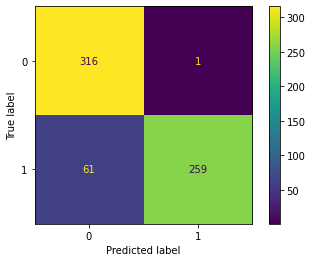

In [58]:
metrics(y_test1, logistic_pred1)

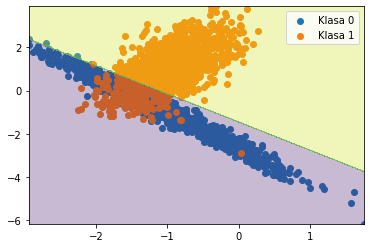

In [59]:
surface(n, x1, y1)

### Zbiór make_moons

In [45]:
n_m = Neuron(activation_function='logistic', n_epoch=10000, eta=0.4, batch_size=64)
n_m.fit(x_train2, y_train2)

In [46]:
logistic_pred2 = n_m.predict(x_test2)

accuracy: 0.10989010989010989
sensitivity: 0.11912225705329153
specificity: 0.10062893081761007


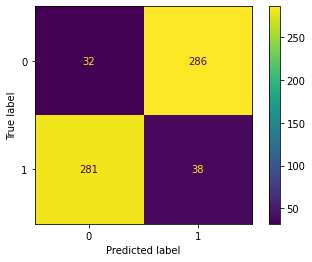

In [47]:
metrics(y_test2, logistic_pred2)

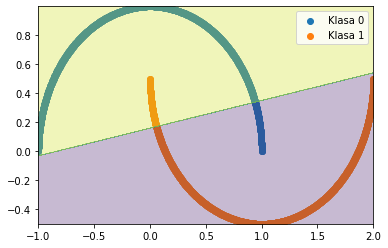

In [48]:
surface(n_m, x2, y2)

## Uczenie i ewaluacja z pozostałymi funkcjami

### Heaviside

Zbiór jednomodowy

In [49]:
n_heaviside = Neuron(activation_function='heaviside', n_epoch=10000, eta=0.5, batch_size=64)
n_heaviside.fit(x_train1, y_train1)

accuracy: 0.880690737833595
sensitivity: 0.775
specificity: 0.9873817034700315


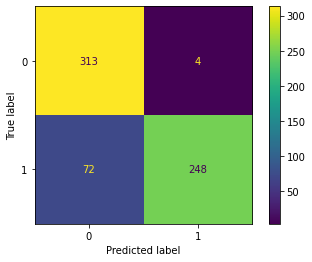

In [50]:
logistic_pred_h1 = n_heaviside.predict(x_test1)
metrics(y_test1, logistic_pred_h1)

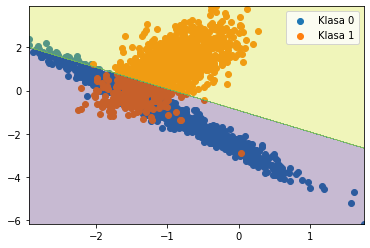

In [51]:
surface(n_heaviside, x1, y1)

Zbiór make_moons

In [329]:
n_heaviside2 = Neuron(activation_function='heaviside', n_epoch=10000, eta=0.15, batch_size=64)
n_heaviside2.fit(x_train2, y_train2)

accuracy: 0.8602825745682888
sensitivity: 0.7554858934169278
specificity: 0.9654088050314465


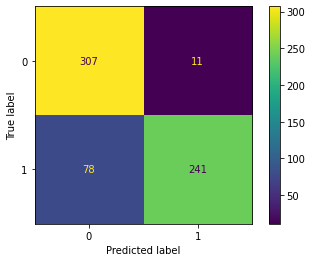

In [330]:
logistic_pred_h2 = n_heaviside2.predict(x_test2)
metrics(y_test2, logistic_pred_h2)

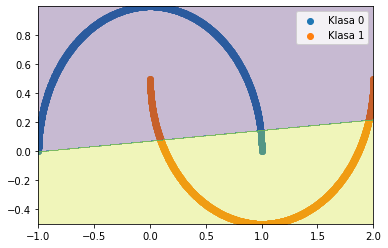

In [331]:
surface(n_heaviside2, x2, y2)

### Sinus

Zbiór jednomodowy

In [335]:
n_sinus = Neuron(activation_function='sin', n_epoch=10000, eta=0.3, batch_size=64)
n_sinus.fit(x_train1, y_train1)

accuracy: 0.9042386185243328
sensitivity: 0.83125
specificity: 0.9779179810725552


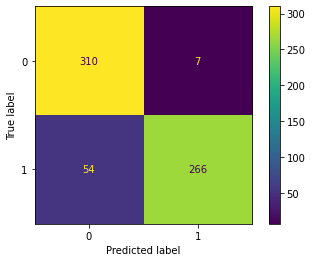

In [336]:
sin_pred1 = n_sinus.predict(x_test1)
metrics(y_test1, sin_pred1)

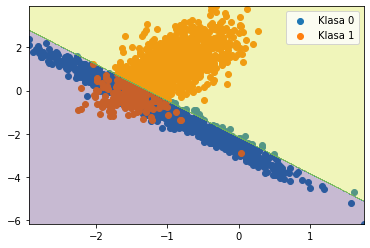

In [337]:
surface(n_sinus, x1, y1)

Zbiór make_moons

In [347]:
n_sinus2 = Neuron(activation_function='sin', n_epoch=10000, eta=0.15, batch_size=64)
n_sinus2.fit(x_train2, y_train2)

accuracy: 0.8398744113029827
sensitivity: 0.6927899686520376
specificity: 0.9874213836477987


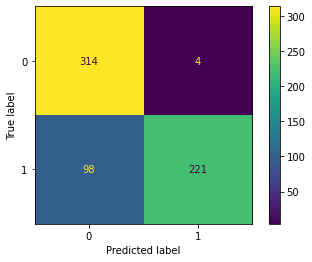

In [348]:
sin_pred2 = n_sinus2.predict(x_test2)
metrics(y_test2, sin_pred2)

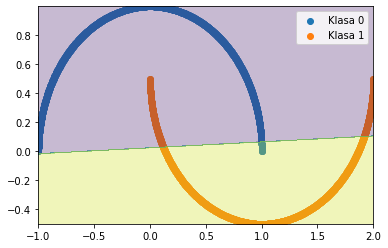

In [349]:
surface(n_sinus2, x2, y2)

### Tanh

Zbiór jednomodowy

In [350]:
n_tanh = Neuron(activation_function='tanh', n_epoch=10000, eta=0.15, batch_size=64)
n_tanh.fit(x_train1, y_train1)

accuracy: 0.902668759811617
sensitivity: 0.815625
specificity: 0.9905362776025236


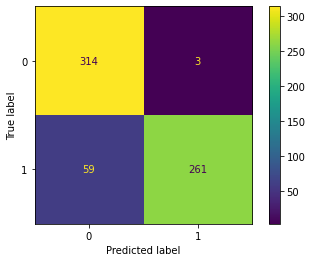

In [351]:
tanh_pred = n_tanh.predict(x_test1)
metrics(y_test1, tanh_pred)

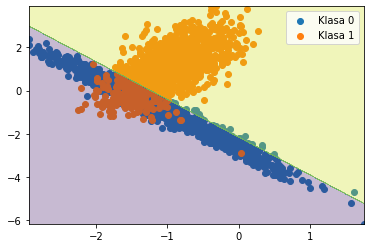

In [352]:
surface(n_tanh, x1, y1)

Zbiór make_moons

In [353]:
n_tanh2 = Neuron(activation_function='tanh', n_epoch=1000, eta=0.15, batch_size=64)
n_tanh2.fit(x_train2, y_train2)

accuracy: 0.8649921507064364
sensitivity: 0.7711598746081505
specificity: 0.9591194968553459


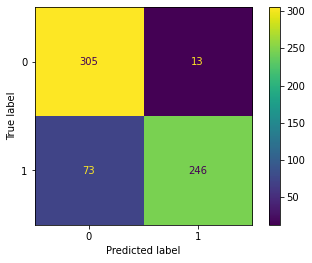

In [354]:
tanh_pred2 = n_tanh2.predict(x_test2)
metrics(y_test2, tanh_pred2)

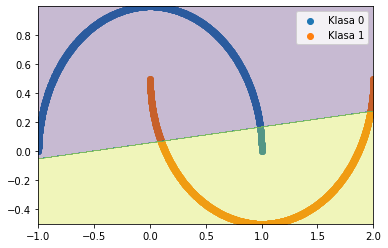

In [355]:
surface(n_tanh2, x2, y2)

### Sign

Zbiór jednomodowy

In [366]:
n_sign = Neuron(activation_function='sign', n_epoch=10000, eta=0.15, batch_size=128)
n_sign.fit(x_train1, y_train1)

accuracy: 0.8979591836734694
sensitivity: 0.853125
specificity: 0.943217665615142


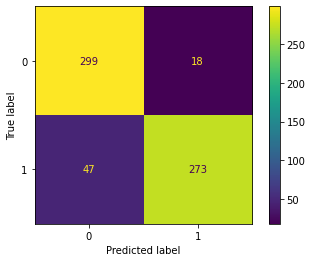

In [367]:
sign_pred = n_sign.predict(x_test1)
metrics(y_test1, sign_pred)

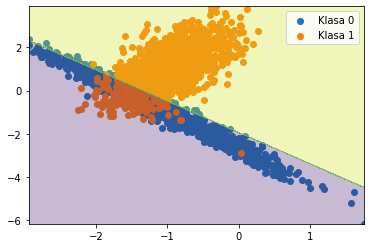

In [368]:
surface(n_sign, x1, y1)

Zbiór make_moons

In [371]:
n_sign2 = Neuron(activation_function='sign', n_epoch=10000, eta=0.3, batch_size=128)
n_sign2.fit(x_train2, y_train2)

accuracy: 0.8854003139717426
sensitivity: 0.8996865203761756
specificity: 0.8710691823899371


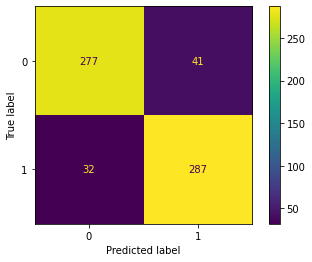

In [372]:
sign_pred2 = n_sign2.predict(x_test2)
metrics(y_test2, sign_pred2)

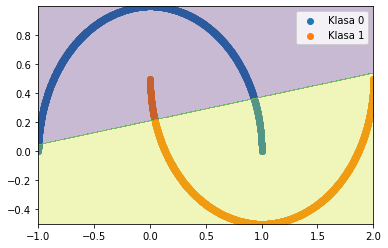

In [373]:
surface(n_sign2, x2, y2)

### ReLu

Zbiór jednomodowy

In [374]:
n_relu = Neuron(activation_function='relu', n_epoch=10000, eta=0.3, batch_size=64)
n_relu.fit(x_train1, y_train1)

accuracy: 0.8916797488226059
sensitivity: 0.784375
specificity: 1.0


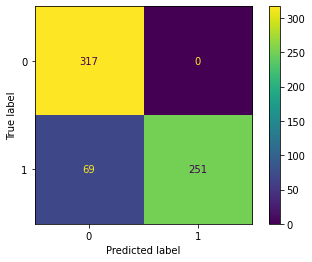

In [375]:
relu_pred = n_relu.predict(x_test1)
metrics(y_test1, relu_pred)

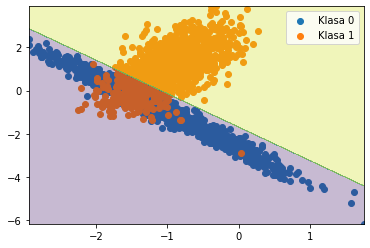

In [376]:
surface(n_relu, x1, y1)

Zbiór make_moons

In [379]:
n_relu2 = Neuron(activation_function='relu', n_epoch=10000, eta=0.5, batch_size=64)
n_relu2.fit(x_train2, y_train2)

accuracy: 0.8665620094191523
sensitivity: 0.7774294670846394
specificity: 0.9559748427672956


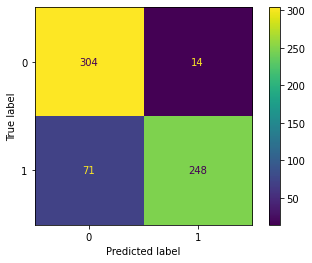

In [380]:
relu_pred2 = n_relu2.predict(x_test2)
metrics(y_test2, relu_pred2)

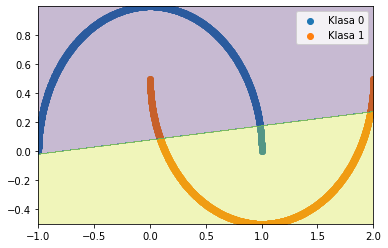

In [381]:
surface(n_relu2, x2, y2)

### Leaky ReLu

Zbiór jednomodowy

In [382]:
leaky_n = Neuron(activation_function='leakyrelu', eta=0.15, batch_size=64, n_epoch=10000)
leaky_n.fit(x_train1, y_train1)

accuracy: 0.9042386185243328
sensitivity: 0.84375
specificity: 0.9652996845425867


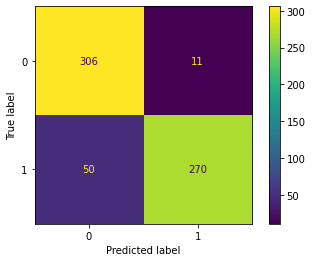

In [383]:
leaky_pred = leaky_n.predict(x_test1)
metrics(y_test1, leaky_pred)

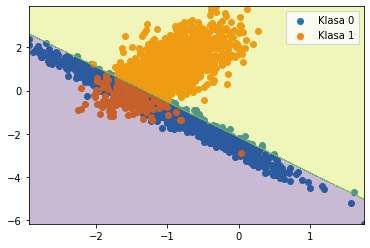

In [385]:
surface(leaky_n, x1, y1)

Zbiór make_moons

In [400]:
leaky_n2 = Neuron(activation_function='leakyrelu', eta=0.05, batch_size=64, n_epoch=10000)
leaky_n2.fit(x_train2, y_train2)

accuracy: 0.8681318681318682
sensitivity: 0.780564263322884
specificity: 0.9559748427672956


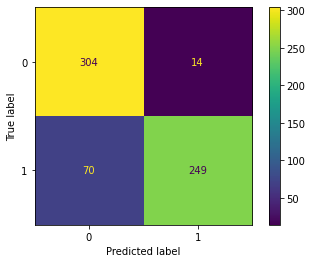

In [401]:
leaky_pred2 = leaky_n2.predict(x_test2)
metrics(y_test2, leaky_pred2)

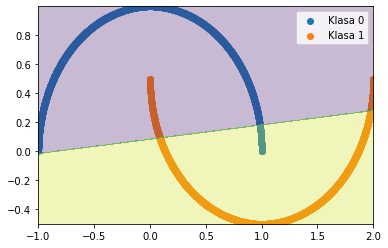

In [402]:
surface(leaky_n2, x2, y2)

## Porównanie czasu uczenia w zależności od wielkości batcha

In [418]:
def plot_batches(activation_func):
    batch = [2**i for i in range(8)]
    czas = []
    
    for bat in batch:
        start = time.time()
        n = Neuron(activation_function=activation_func, batch_size=bat, n_epoch=100)
        n.fit(x_train1, y_train1)
        end = time.time()
        czas.append(end-start)
    
    plt.plot(batch, czas)
    plt.xlabel('batch size')
    plt.ylabel('czas')
    plt.title(activation_func)
    plt.show()

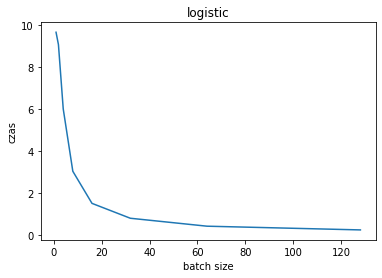

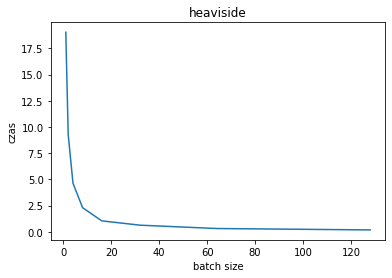

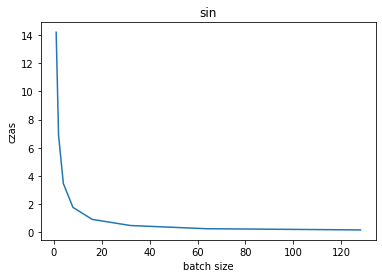

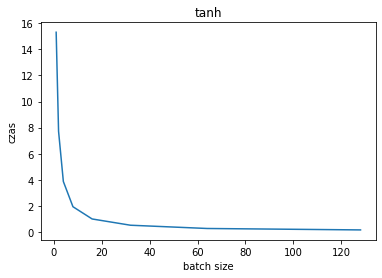

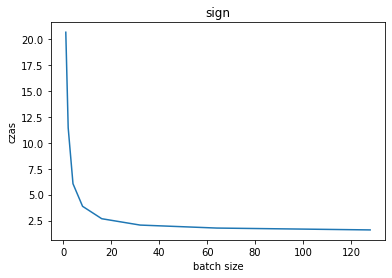

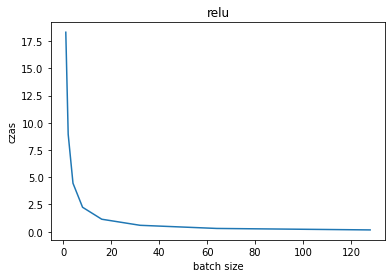

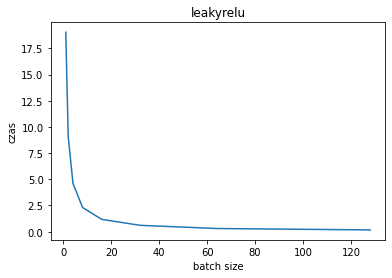

In [419]:
ac = ['logistic', 'heaviside', 'sin', 'tanh', 'sign', 'relu', 'leakyrelu']

for acc in ac:
    plot_batches(acc)

## Uczenie z wykorzystaniem zmiennej szybkości uczenia

### Logistic

In [53]:
n = Neuron(activation_function='logistic', n_epoch=10000, batch_size=64, cos_ann=True, eta_min=0.05, eta_max=0.6)
n.fit(x_train1, y_train1)

accuracy: 0.9042386185243328
sensitivity: 0.83125
specificity: 0.9779179810725552


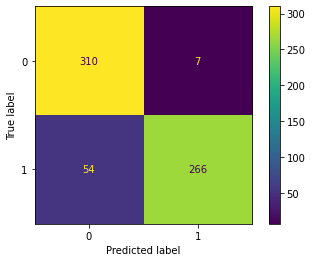

In [54]:
logistic_pred3 = n.predict(x_test1)
metrics(y_test1, logistic_pred3)

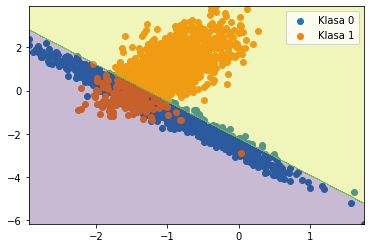

In [55]:
surface(n, x1, y1)

### Heaviside

In [60]:
n_heaviside = Neuron(activation_function='heaviside', n_epoch=10000, batch_size=64, cos_ann=True, eta_min=0.05, eta_max=0.5)
n_heaviside.fit(x_train1, y_train1)

accuracy: 0.8712715855572999
sensitivity: 0.74375
specificity: 1.0


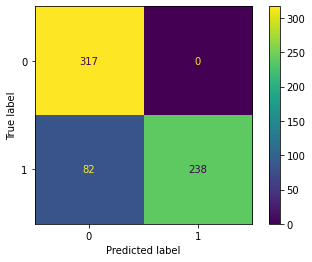

In [61]:
logistic_pred_h1 = n_heaviside.predict(x_test1)
metrics(y_test1, logistic_pred_h1)

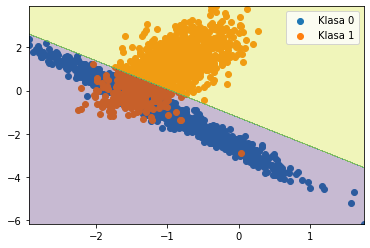

In [62]:
surface(n_heaviside, x1, y1)

### Sinus

In [69]:
n_sinus = Neuron(activation_function='sin', n_epoch=10000, batch_size=64, cos_ann=True, eta_min=0.05, eta_max=0.5)
n_sinus.fit(x_train1, y_train1)

accuracy: 0.8775510204081632
sensitivity: 0.75625
specificity: 1.0


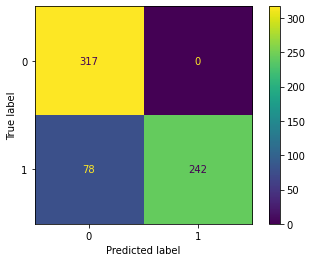

In [70]:
sin_pred1 = n_sinus.predict(x_test1)
metrics(y_test1, sin_pred1)

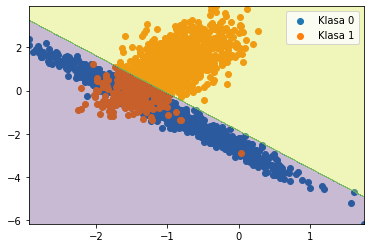

In [71]:
surface(n_sinus, x1, y1)

### Tanh

In [75]:
n_tanh = Neuron(activation_function='tanh', n_epoch=10000, batch_size=64, cos_ann=True, eta_min=0.05, eta_max=0.3)
n_tanh.fit(x_train1, y_train1)

accuracy: 0.9042386185243328
sensitivity: 0.840625
specificity: 0.9684542586750788


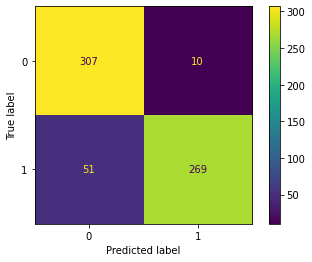

In [76]:
tanh_pred = n_tanh.predict(x_test1)
metrics(y_test1, tanh_pred)

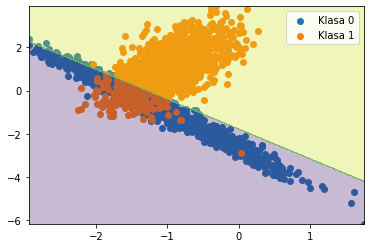

In [77]:
surface(n_tanh, x1, y1)

### Sign

In [78]:
n_sign = Neuron(activation_function='sign', n_epoch=10000, batch_size=128, cos_ann=True, eta_min=0.05, eta_max=0.5)
n_sign.fit(x_train1, y_train1)

accuracy: 0.8901098901098901
sensitivity: 0.78125
specificity: 1.0


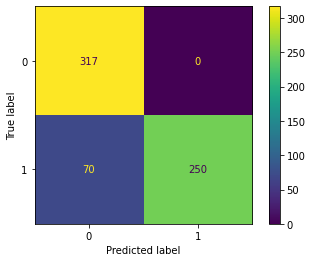

In [79]:
sign_pred = n_sign.predict(x_test1)
metrics(y_test1, sign_pred)

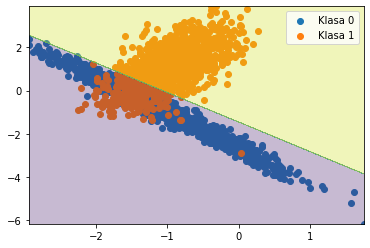

In [80]:
surface(n_sign, x1, y1)

### ReLU

In [81]:
n_relu = Neuron(activation_function='relu', n_epoch=10000, batch_size=64, cos_ann=True, eta_min=0.05, eta_max=0.5)
n_relu.fit(x_train1, y_train1)

accuracy: 0.9058084772370487
sensitivity: 0.8125
specificity: 1.0


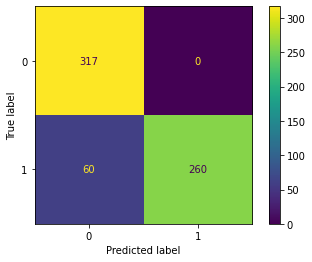

In [82]:
relu_pred = n_relu.predict(x_test1)
metrics(y_test1, relu_pred)

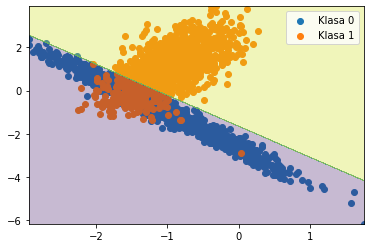

In [83]:
surface(n_relu, x1, y1)

### LeakyReLU

In [90]:
leaky_n = Neuron(activation_function='leakyrelu', batch_size=64, n_epoch=10000, cos_ann=True, eta_min=0.05, eta_max=0.4)
leaky_n.fit(x_train1, y_train1)

accuracy: 0.9105180533751962
sensitivity: 0.83125
specificity: 0.9905362776025236


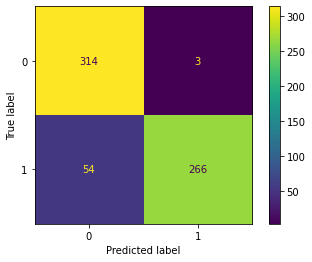

In [91]:
leaky_pred = leaky_n.predict(x_test1)
metrics(y_test1, leaky_pred)

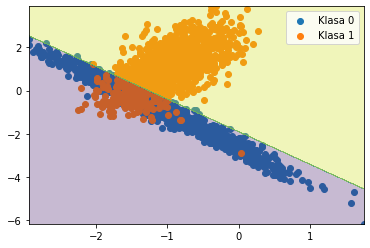

In [92]:
surface(leaky_n, x1, y1)